# Beetle Disturbance Analysis in Western US Forests

This notebook processes forest disturbance data across the Western United States to identify areas impacted by bark beetle infestations over time. The workflow involves reading forest disturbance data for each year, isolating disturbance due to beetles, and generating raster files that show beetle presence across different time periods.

The analysis includes:
- Identifying beetle-impacted areas by processing annual forest disturbance raster data.
- Aggregating beetle presence data over five-year periods to track regions experiencing two or more years of beetle-related forest disturbance.
- Summarizing the total area affected by beetles over five-year intervals and visualizing these trends with a plot.

The output includes:
- Geospatial raster files showing beetle presence per year.
- Five-year aggregated raster files showing the total number of beetle-impacted years.
- A plot visualizing the total area affected by beetles over five-year periods.

This analysis provides insights into the spatial and temporal patterns of beetle infestations in Western US forests.


In [14]:
# Import packages and make file paths
import os
from glob import glob
import earthpy as et
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import gc

home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

forest_folder = path.join(home, "forest-disturbance-stack", "western-conus")
beetle_folder = path.join(home, "forest-disturbance-stack", "beetle-western-conus")
fiveyear_beetle_folder = path.join(home, "forest-disturbance-stack", "five-year-beetle")

if not os.path.isdir(beetle_folder):
    os.mkdir(beetle_folder)
if not os.path.isdir(fiveyear_beetle_folder):
    os.mkdir(fiveyear_beetle_folder)

In [17]:
# Loop through each year of forest disturbances for a 5 year period and calculate where beetle disturbances were present
forest_tif_list = sorted(glob(path.join(forest_folder, "forest-disturbance-stack_western-conus_*.tif")))

for tif in forest_tif_list:
    year = tif[-8:-4]
    print(year)
    with rio.open(tif) as src:
        array = src.read(1)
        meta = src.profile
    array[array == 2] = 1
    array[array == 6] = 1
    array[array == 10] = 1
    array[array == 14] = 1
    array[array != 1] = 0
    with rio.open(path.join(beetle_folder, "beetle_presence_{}.tif".format(year)), 'w', **meta) as dst:
        dst.write(array, 1)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [19]:
# Find all areas that had more than one beetle disturbance in each time period
beetle_tif_list = sorted(glob(path.join(beetle_folder, "beetle_presence_*.tif")))
year_totals_over_2 = {}

for i, tif in enumerate(beetle_tif_list):
    if i >=4:
        years = beetle_tif_list[i-4:i+1]
        start_year = years[0][-8:-4]
        end_year = years[4][-8:-4]
        print("Processing years {} to {}".format(start_year, end_year))
        with rio.open(years[0]) as src:
            years_array = src.read(1)
            meta = src.profile
        for year in years[1:]:
            with rio.open(year) as src:
                array = src.read(1)
            years_array += array
            del(array)
            gc.collect()
        with rio.open(path.join(fiveyear_beetle_folder, "beetle_totals_{}-.{}.tif".format(start_year, end_year)), 'w', **meta) as dst:
            dst.write(years_array, 1)
        years_array[years_array <= 1] = 0
        years_array[years_array > 1] = 1
        year_totals_over_2[end_year] = (years_array.sum()* 30 * 30)/1000000    
        del(years_array)
        gc.collect()
            
        

Processing years 1999 to 2003
Processing years 2000 to 2004
Processing years 2001 to 2005
Processing years 2002 to 2006
Processing years 2003 to 2007
Processing years 2004 to 2008
Processing years 2005 to 2009
Processing years 2006 to 2010
Processing years 2007 to 2011
Processing years 2008 to 2012
Processing years 2009 to 2013
Processing years 2010 to 2014
Processing years 2011 to 2015
Processing years 2012 to 2016
Processing years 2013 to 2017
Processing years 2014 to 2018
Processing years 2015 to 2019
Processing years 2016 to 2020


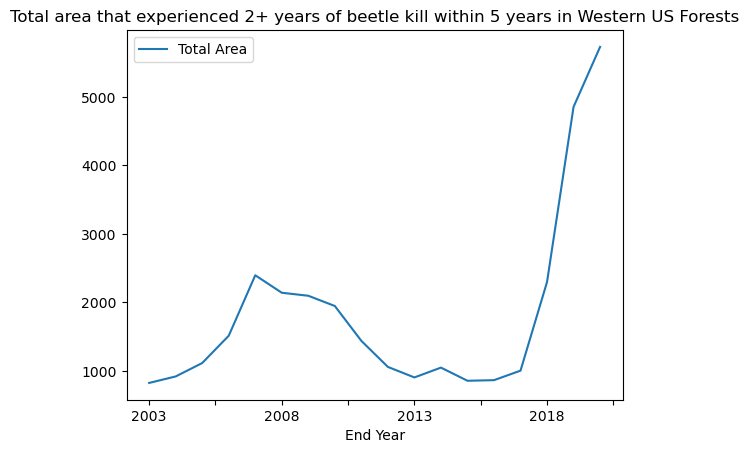

In [21]:
# Rearrange data and plot it
years = list(year_totals_over_2.keys())
area = list(year_totals_over_2.values())
data = {'End Year': years, 'Total Area': area}
short_term_plot = pd.DataFrame(data)

fig, ax = plt.subplots()
short_term_plot.plot('End Year',
                    y='Total Area', 
                    title='Total area that experienced 2+ years of beetle kill within 5 years in Western US Forests',
                    ax=ax)
plt.savefig(os.path.join(fiveyear_beetle_folder, "fiveyear_beetle.png"))
plt.show()

In [22]:
short_term_plot.to_csv(os.path.join(fiveyear_beetle_folder, 'beetle_area_over_time.csv'))